In [1]:
import astropy.units as u
import astropy.constants as c
from astropy.modeling.physical_models import BlackBody
import numpy as np
import matplotlib.pyplot as plt

# Define SED class
class SED:

    # Initialize the class
    def __init__(self, mag, temperature, temp_units, wave_start, wave_stop, wave_units):
        
        # Define variables
        self.mag = mag
        self.temperature = temperature

        # Define the units of temperature
        if temp_units == 'Kelvin':
            self.temperature = self.temperature*u.K

        # Define the wavelength range
        self.wave_start = wave_start
        self.wave_stop = wave_stop

        # Define the units of wavelength
        if wave_units == "Angstrom":
            self.wave_start = self.wave_start*u.AA
            self.wave_stop = self.wave_stop*u.AA

    def create_spectrum(self):

        '''
        PURPOSE:
                This function creates a blackbody spectrum based on the temperature and magnitude of the star.

        INPUTS:
                        [mag; float]: The magnitude of the star
                [temperature; float]: The temperature of the star
                 [wave_start; float]: The starting wavelength of the spectrum
                  [wave_stop; float]: The ending wavelength of the spectrum

        OUTPUTS:
                          [wavelength; np.array, float]: The wavelength array of the blackbody spectrum
                [normalized_spectrum,; np.array, float]: The normalized blackbody spectrum

        AUTHOR:
                Tim M. Sept. 1 2023.
        '''

        # Create the blackbody spectrum
        blackbody_model = BlackBody(self.temperature, scale = 1*u.erg/u.s/u.cm**2/u.sr/u.AA)

        # Normalize the spectrum
        self.wavelength = np.linspace(self.wave_start, self.wave_stop, 100_000)

        # Define the reference spectrum
        self.model_spectrum = blackbody_model(self.wavelength)
        
        # Normalize the spectrum
        ref_spectrum = BlackBody(temperature = 9_700*u.K, scale = 1*u.erg/u.s/u.cm**2/u.sr/u.AA)

        # Normalize the spectrum
        normalize = (3.63e-9*u.erg/u.cm**2/u.s/u.AA)/(ref_spectrum(5500*u.AA)*u.sr) 

        # Define the normalized spectrum
        self.normalized_spectrum = self.model_spectrum*u.sr*normalize*10.**(-0.4*self.mag)
        
        return self.wavelength, self.normalized_spectrum
    
    def photon_spectrum(self):
        '''
        PURPOSE:
            Create a photon spectrum
        INPUTS:
            Self
        OUTPUTS:
            photon_spectrum, an array in units of photons per second per cm^2 per Angstrom
        '''
        wavelength,normalized_spectrum = SED.create_spectrum(self)
        
        light_speed = c.c.to(u.cm/u.s)
        h = c.h.to(u.erg*u.s)
        
        photon_spectrum = normalized_spectrum*(5500*u.AA.to(u.cm)*u.cm)/(h*light_speed)
        return wavelength,photon_spectrum
    
    def plot(self, plot):

        '''
        PURPOSE:
                This function plots the blackbody spectrum.

        INPUTS:
                [plot; string:  Type of plot

        OUTPUTS:
                Displays a plot of the blackbody spectrum.

        AUTHOR:
                Tim M. Sept. 1 2023.
        '''

        # Create normalized spectrum 
        if plot=='Flux Density':
        
            wavelength, spectrum = SED.create_spectrum(self)
            fig,ax = plt.subplots(1, 1, figsize = (10, 8))
            ax.set_xlabel('Wavelength ($\AA$)')
            ax.set_ylabel('Flux Density (ergs $s^{-1} cm^{-2} \AA^{-1}$)')
            ax.plot(wavelength, spectrum)
            plt.show()
        
        if plot=='Photon Flux':
            wavelength, spectrum = SED.photon_spectrum(self)
            fig,ax = plt.subplots(1, 1, figsize = (10, 8))
            ax.set_xlabel('Wavelength ($\AA$)')
            ax.set_ylabel('Flux Density (photons $s^{-1} cm^{-2} \AA^{1})$')
            ax.plot(wavelength, spectrum)
            plt.show()
        
        return 
        
class BandPass:

    # Initialize the bandpass class
    def __init__(self, filter):


        # For the Johnson V filter
        if filter == 'V':

            # Define the wavelength range
            self.filter_wavelength = np.arange(0, 10_000)

            # Make the filter array of zeros
            self.filter = np.zeros(len(self.filter_wavelength))

            # Make a boxy filter response
            index = np.where((self.filter_wavelength > 5075) & (self.filter_wavelength < 5925))
            self.filter[index] = 1
            
    def convolve_SED(self, wavelength, normalized_spectrum):

        ''' 
        PURPOSE:
                Function that convolves the normalized spectrum with a filter response function.

        INPUTS:
                N/A

        OUTPUTS:
                [convolved_spectrum; np.array, float]:  Normalized spectrum convolved with the filter response.

        AUTHOR:
                Tim M. Sept. 1 2023.
        '''

        # Interpolate the filter response
        interpolated_filter_values = np.interp(wavelength.value, self.filter_wavelength, self.filter)
        
        # Multiply the normalized spectrum by the interpolated filter values
        convolved_spectrum = normalized_spectrum*interpolated_filter_values
        
        return convolved_spectrum
    
class Telescope:
    '''
    PURPOSE:
        Define telescope parameters to determine collecting area
    INPUTS:
        diameter: diameter of primary mirror
        units: units of length for diameter
        
            
    '''
    def __init__(self,diameter,units):
        if units == 'cm':
            self.diameter = diameter*u.cm
        if units == 'm':
            self.diameter = diameter*u.m.to(u.cm)*u.cm
        if units == 'mm':
            self.diameter = diameter*u.mm.to(u.cm)*u.cm
    def calc_area(self):    
        area = np.pi*(self.diameter/2)**2
        return area
    
class atmosphere:
    '''
    PURPOSE:
        Define absorption due to atmospheric conditions
        
    INPUTS:
        quality: Either 'good' or 'bad' observing conditions
    '''
    
    def __init__(self,quality):
        if quality=='good':
            self.atm = 0.8
        if quality=='bad':
            self.atm = 0.4
    def get_atm(self):
        atm = self.atm
        return atm
            
class Detector:
    def __init__(self,name):
        self.name = name

    def detector_efficiency(self):   
    
        if camera_cost == '$$$':
            QE = 0.5
        if camera_cost == '$':
            QE = 0.08
        return QE

C:\ProgramData\Anaconda3\lib\site-packages\astropy\units\quantity.py:611: RuntimeWarning: overflow encountered in expm1
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\astropy\units\quantity.py:611: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


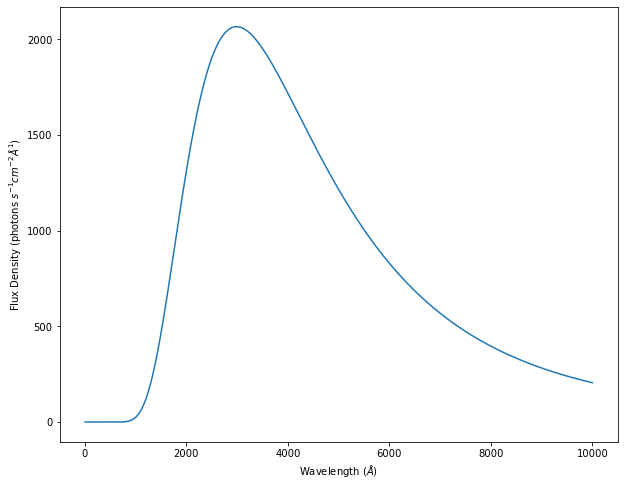

In [2]:
# Initialize the SED class
model = SED(mag = 0, temperature = 9700, temp_units = 'Kelvin', wave_start = 1, wave_stop = 10_000, wave_units = 'Angstrom')

# Create the spectrum
wavelength,normalized_spectrum = model.create_spectrum()
model.plot(plot='Photon Flux')

Text(0, 0.5, 'Flux Density (photons $s^{-1} cm^{-2} \\AA^{1})$')

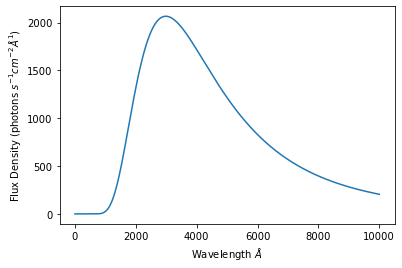

In [19]:
photon_spectrum = model.photon_spectrum()

plt.plot(wavelength,photon_spectrum)
plt.xlabel('Wavelength $\AA$')
plt.ylabel('Flux Density (photons $s^{-1} cm^{-2} \AA^{1})$')

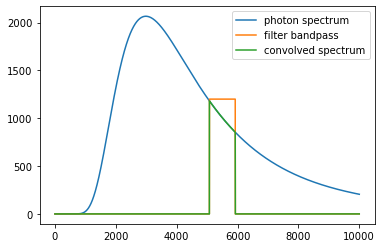

In [20]:
# Initialize the BandPass class
Vband = BandPass('V')

# Convolve the spectrum with the filter response
convolved_spectrum = Vband.convolve_SED(wavelength, photon_spectrum)

# Plot the convolved spectrum
plt.plot(wavelength,photon_spectrum,label='photon spectrum')
plt.plot(Vband.filter_wavelength,Vband.filter*1200,label='filter bandpass')
plt.plot(wavelength,convolved_spectrum,label='convolved spectrum')
plt.legend()

In [21]:
timstelescope = Telescope(80,'mm')

area = timstelescope.calc_area()

area

<Quantity 50.26548246 cm2>